<a href="https://colab.research.google.com/github/KevinWang676/DDPM-IP/blob/DDPM-IP/Improved_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep denoising auto-encoder and MLP based multi-output regression on TCGA multi-omics data
## DNA Methylation and CNA to RNA-Seq

# Setting environment

Seeding the random number generators

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            # have reproducible behavior for certain hash-based operations.
import os
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
import numpy as np
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
import random as rn
rn.seed(12345)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
import tensorflow as tf
tf.random.set_seed(1234)

# Force TensorFlow to use single thread.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
#from keras import backend as K
from tensorflow.python.keras import backend as K

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)


Importing libraries

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [3]:
def rSquared(true,predicted):
    cols = predicted.shape[1]
    rsq = np.zeros(shape=(cols), dtype = np.float32)
    for j in range(cols):
        rsq[j] = r2_score(true[:,j], predicted[:,j])
    return rsq

# Loading data

Importing data from pre-processed csv files (Change paths accordingly)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#ls "/content/drive/My Drive"

In [6]:
preprocessed_DNAMeth = pd.read_csv('/content/drive/My Drive/Preprocessed_Data/LIHC_preprocessed_DNAMeth.csv')
preprocessed_RNASeq = pd.read_csv('/content/drive/My Drive/Preprocessed_Data/LIHC_preprocessed_RNASeq.csv')
preprocessed_CNA = pd.read_csv('/content/drive/My Drive/Preprocessed_Data/LIHC_preprocessed_CNA.csv')
labels = pd.read_csv('/content/drive/My Drive/Preprocessed_Data/LIHC_labels.csv')

In [7]:
x1 = preprocessed_DNAMeth
x2 = preprocessed_CNA
y = preprocessed_RNASeq

Concatenating Methylation and CNV features

In [8]:
x1 = pd.DataFrame(x1)
x2 = pd.DataFrame(x2)
df = [x1, x2]
z = pd.concat(df,axis=1)

Splitting the data into training and testing datasets

In [9]:
x_train, x_test, y_train, y_test, labels_train, labels_test = train_test_split(z, y, labels, test_size=0.2)

Scaling the data within [0-1] range

In [10]:
scalar = MinMaxScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

Adding gaussian noise

In [11]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(0.0, 1.0, x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Dimension Reduction/Feature Extraction using DDAE

Setting the no. of input and output neurons

In [12]:
num_in_neurons = z.shape[1]
num_out_neurons = y.shape[1]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

def lr_time_based_decay(epoch, lr):
    """Learning rate scheduler function."""
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

with tf.device('/gpu:0'):
    # this is the size of our encoded representations
    encoding_dim1 = 500
    encoding_dim2 = 200
    lambda_act = 0.0001
    lambda_weight = 0.001
    input_data = Input(shape=(num_in_neurons,))   # this is our input placeholder
    # first encoded representation of the input
    encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act),
             kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)
    # second encoded representation of the input
    encoded = Dense(encoding_dim2, activation='relu', activity_regularizer=regularizers.l1(lambda_act),
             kernel_regularizer=regularizers.l2(lambda_weight), name='encoder2')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)
    # first lossy reconstruction of the input
    decoded = Dense(encoding_dim1, activation='relu', name='decoder1')(encoded)
    decoded = BatchNormalization()(decoded)
    # the final lossy reconstruction of the input
    decoded = Dense(num_in_neurons, activation='sigmoid', name='decoder2')(decoded)
    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_data, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    # setup callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
        LearningRateScheduler(lr_time_based_decay, verbose=1)
    ]
    print('Training the autoencoder')   # training
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=25,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=callbacks)
    autoencoder.load_weights('best_model.h5')   # Load best model
    autoencoder.trainable = False   # Freeze the weights



Training the autoencoder

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
40/41 [============================>.] - ETA: 0s - loss: 0.4836
Epoch 1: val_loss improved from inf to 0.35046, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 14s 191ms/step - loss: 0.4823 - val_loss: 0.3505 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009990010464510004.
Epoch 2/25
40/41 [============================>.] - ETA: 0s - loss: 0.2741
Epoch 2: val_loss improved from 0.35046 to 0.30455, saving model to best_model.h5
41/41 [==============================] - 7s 178ms/step - loss: 0.2741 - val_loss: 0.3045 - lr: 9.9900e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009970070734739065.
Epoch 3/25
40/41 [============================>.] - ETA: 0s - loss: 0.3605
Epoch 3: val_loss did not improve from 0.30455
41/41 [==============================] - 1s 20ms/step - loss: 0.3611 - val_loss: 0.4462 - lr: 9.9701e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009940250508360944.
Epoch 4/25
40/41 [============================>.] - ETA: 0s - loss: 0.3989
Epoch 4: val_loss did not improve from 0.30455
41/41 [==============================] - 1s 2

### VAE-like model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras import backend as K

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def lr_time_based_decay(epoch, lr):
    """Learning rate scheduler function."""
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

with tf.device('/gpu:0'):
    # this is the size of our encoded representations
    encoding_dim1 = 500
    encoding_dim2 = 200
    lambda_act = 0.0001
    lambda_weight = 0.001
    input_data = Input(shape=(num_in_neurons,))   # this is our input placeholder
    # first encoded representation of the input
    encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act),
             kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)
    # second encoded representation of the input
    encoded = Dense(encoding_dim2, activation='relu', activity_regularizer=regularizers.l1(lambda_act),
             kernel_regularizer=regularizers.l2(lambda_weight), name='encoder2')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.5)(encoded)

    z_mean = Dense(encoding_dim2, name='z_mean')(encoded)
    z_log_var = tf.ones_like(encoded)

    # Use reparameterization trick to push the sampling out as input
    z = Lambda(sampling, output_shape=(encoding_dim2,), name='z')([z_mean, z_log_var])

    # first lossy reconstruction of the input
    decoded = Dense(encoding_dim1, activation='relu', name='decoder1')(z)
    decoded = BatchNormalization()(decoded)
    # the final lossy reconstruction of the input
    decoded = Dense(num_in_neurons, activation='sigmoid', name='decoder2')(decoded)
    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_data, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    # setup callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
        LearningRateScheduler(lr_time_based_decay, verbose=1)
    ]
    print('Training the autoencoder')   # training
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=25,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test),
                    callbacks=callbacks)
    autoencoder.load_weights('best_model.h5')   # Load best model
    autoencoder.trainable = False   # Freeze the weights



Training the autoencoder

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/25
40/41 [============================>.] - ETA: 0s - loss: 0.4765
Epoch 1: val_loss improved from inf to 0.31248, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 16s 78ms/step - loss: 0.4750 - val_loss: 0.3125 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009990010464510004.
Epoch 2/25
40/41 [============================>.] - ETA: 0s - loss: 0.2482
Epoch 2: val_loss improved from 0.31248 to 0.27341, saving model to best_model.h5
41/41 [==============================] - 3s 76ms/step - loss: 0.2483 - val_loss: 0.2734 - lr: 9.9900e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009970070734739065.
Epoch 3/25
41/41 [==============================] - ETA: 0s - loss: 0.3268
Epoch 3: val_loss did not improve from 0.27341
41/41 [==============================] - 1s 33ms/step - loss: 0.3268 - val_loss: 0.3489 - lr: 9.9701e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009940250508360944.
Epoch 4/25
40/41 [============================>.] - ETA: 0s - loss: 0.2945
Epoch 4: val_loss improved from 0.27341 to 0.26746, saving model to best_model.h5
41/41 [=====

In [15]:
"""
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import HeNormal

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

num_in_neurons = x_train_noisy.shape[1]

# Network parameters

encoding_dim1 = 500
encoding_dim2 = 200

lambda_act = 0.0001
lambda_weight = 0.001
kl_weight = 0.001  # Weight of KL divergence in loss calculation

# VAE model = encoder + decoder
# build encoder model
with tf.device('/gpu:0'):
    inputs = Input(shape=(num_in_neurons,), name='encoder_input')
    x = Dense(encoding_dim1, activation='relu', kernel_initializer=HeNormal(),
              activity_regularizer=regularizers.l1(lambda_act),
              kernel_regularizer=regularizers.l2(lambda_weight))(inputs)
    x = Dense(encoding_dim2, activation='relu', kernel_initializer=HeNormal())(x)

    z_mean = Dense(encoding_dim2, name='z_mean')(x)
    z_log_var = tf.ones_like(x)

    # Use reparameterization trick to push the sampling out as input
    z = Lambda(sampling, output_shape=(encoding_dim2,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_inputs = Input(shape=(encoding_dim2,), name='z_sampling')
    x = Dense(encoding_dim2, activation='relu')(latent_inputs)
    x = Dense(encoding_dim1, activation='relu')(x)
    outputs = Dense(num_in_neurons, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

# VAE loss = binary_crossentropy + kl_loss
reconstruction_loss = BinaryCrossentropy(from_logits=True)(inputs, outputs)
reconstruction_loss *= num_in_neurons
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5 * kl_weight
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
optimizer = Adam(lr=0.0005, clipvalue=1.0)  # Using a learning rate scheduler or different optimizer
vae.compile(optimizer=optimizer)

# Train the autoencoder
vae.fit(x_train_noisy, x_train,
        epochs=25,
        batch_size=8,
        shuffle=True,
        validation_data=(x_test_noisy, x_test))
"""

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

# Regression using MLP

In [16]:
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
# create regression model
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'
    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)
    y_pred = mlpRegressor.predict(x_test)
    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))


training the MLP multi-output regressor
Epoch 1/50
41/41 [==============================] - 2s 17ms/step - loss: 0.1678 - accuracy: 0.0000e+00
Epoch 2/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1636 - accuracy: 0.0000e+00
Epoch 3/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1626 - accuracy: 0.0000e+00
Epoch 4/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1625 - accuracy: 0.0000e+00
Epoch 5/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1624 - accuracy: 0.0000e+00
Epoch 6/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1621 - accuracy: 0.0000e+00
Epoch 7/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1618 - accuracy: 0.0000e+00
Epoch 8/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1617 - accuracy: 0.0000e+00
Epoch 9/50
41/41 [==============================] - 1s 14ms/step - loss: 0.1613 - accuracy: 0.0000e+00
Epoch 10/50
41/41 [==============

In [ ]:
"""
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 1), activation='relu', name='hidden3')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)

    y_pred = mlpRegressor.predict(x_test)

    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
"""

# Results

In [17]:
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))

MSE: (Actual Vs. Predicted) 0.016789430499671743
r^2 value: (Mean of actual Vs. Mean of Predicted) 0.9801043650648991


Plotting predicted Vs. Actual

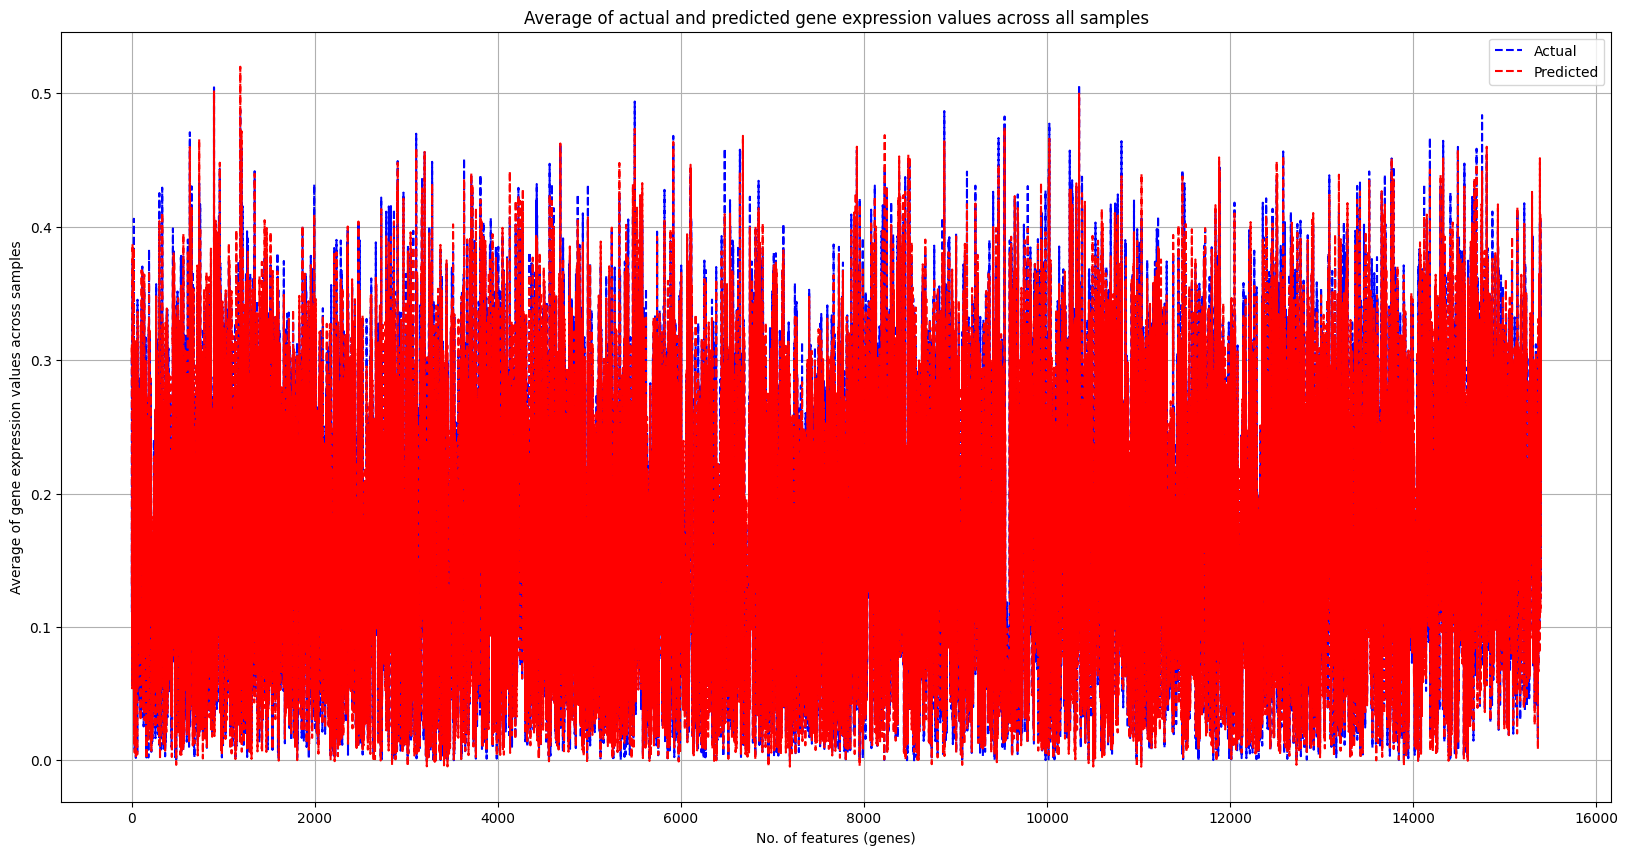

In [ ]:
act=actual_mean.values.flatten()
pred=pred_mean.values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('Average of actual and predicted gene expression values across all samples')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting first 100 features

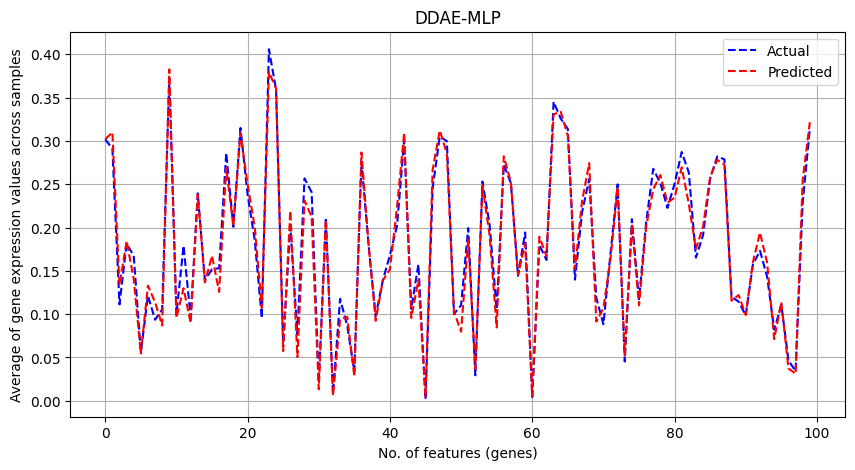

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('DDAE-MLP')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting correlation scatter plot for mean of actual Vs. mean of predicted gene expressions

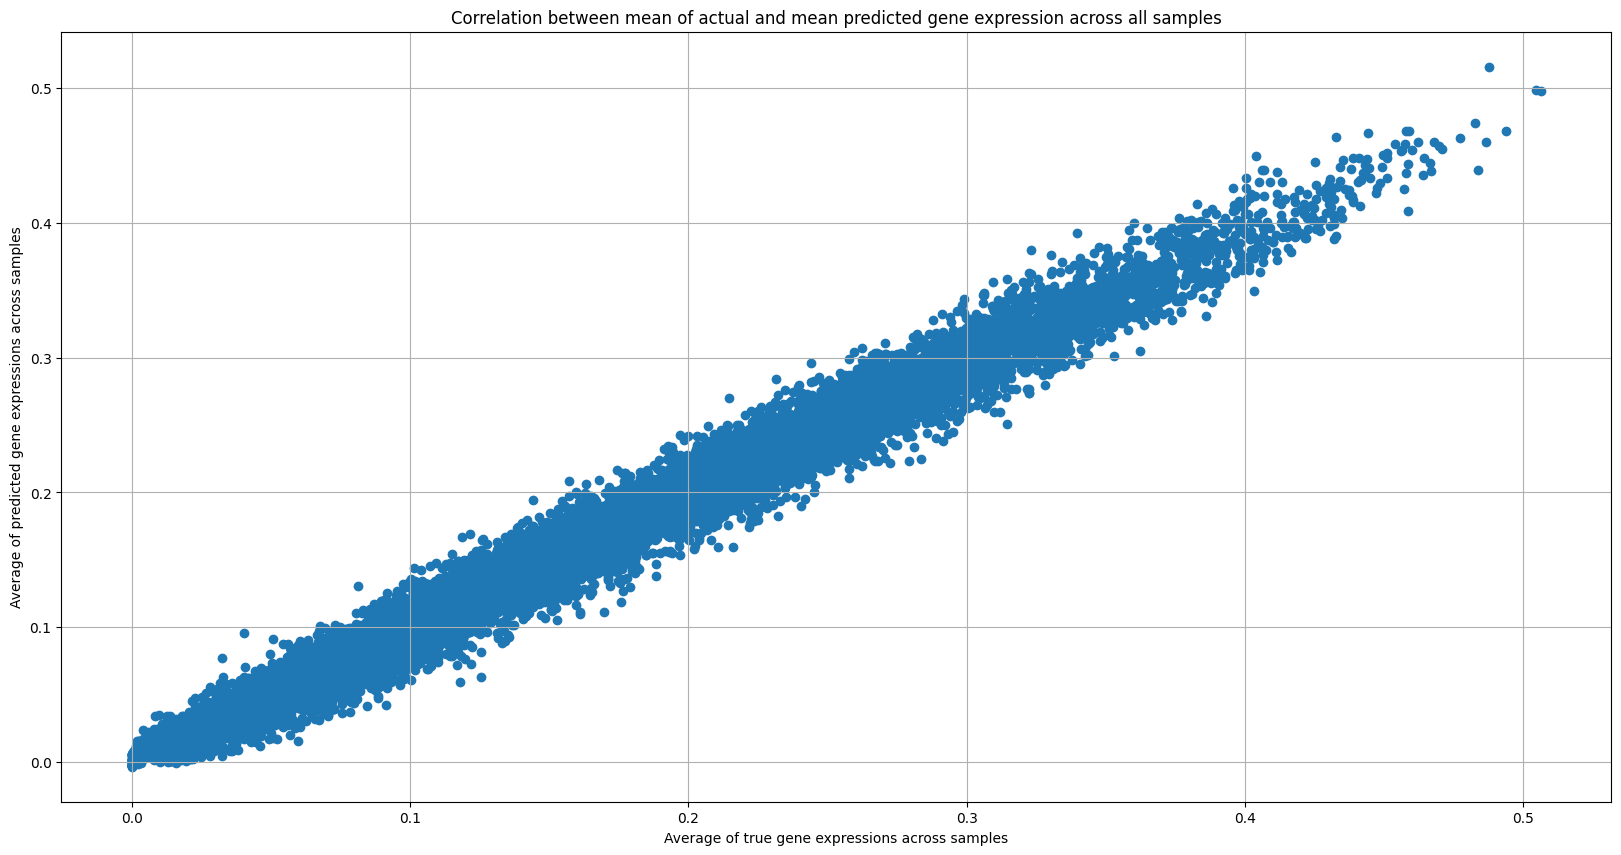

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(actual_mean, pred_mean)
plt.title('Correlation between mean of actual and mean predicted gene expression across all samples')
plt.xlabel('Average of true gene expressions across samples')
plt.ylabel('Average of predicted gene expressions across samples')
plt.grid(True)
plt.show()


# Classification of Tumor and Normal samples using MLP

Importing libraries

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

MLP-classifier

In [ ]:
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)     # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)     # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)     # adding 50% dropout
    y = Dense(1, activation='sigmoid', name='predictions')(h)

    classifier = Model(inputs=autoencoder.inputs, outputs=y)
    # Compile model
    classifier.compile(loss='binary_crossentropy', optimizer='adam',
                   metrics=['accuracy'])
    # Fit the model
    classifier.fit(x_train, labels_train, epochs=25, batch_size=8)

    print('Now making predictions')
    predictions = classifier.predict(x_test)
    rounded_predictions = [round(x[0]) for x in predictions]

Epoch 1/25
41/41 [==============================] - 2s 5ms/step - loss: 0.9399 - accuracy: 0.8793
Epoch 2/25
41/41 [==============================] - 0s 5ms/step - loss: 0.7219 - accuracy: 0.8824
Epoch 3/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5912 - accuracy: 0.8762
Epoch 4/25
41/41 [==============================] - 0s 5ms/step - loss: 0.6038 - accuracy: 0.9040
Epoch 5/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5516 - accuracy: 0.9102
Epoch 6/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5815 - accuracy: 0.9040
Epoch 7/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5452 - accuracy: 0.9102
Epoch 8/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5235 - accuracy: 0.9071
Epoch 9/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5697 - accuracy: 0.9102
Epoch 10/25
41/41 [==============================] - 0s 5ms/step - loss: 0.5487 - accuracy: 0.9102
Epoch 11/25
41/41 [

Evaluating the model

In [ ]:
_, train_acc = classifier.evaluate(x_train, labels_train, verbose=0)
_, test_acc = classifier.evaluate(x_test, labels_test, verbose=0)
print('\nTraining accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))
print("Recall score = ",recall_score(labels_test, rounded_predictions))
cm = confusion_matrix(labels_test, rounded_predictions)
print("Confusion matrix:")
print(cm)
report = classification_report(labels_test, rounded_predictions)
print("classification_report")
print(report)


Training accuracy: 0.910, Testing accuracy: 0.877
Recall score =  1.0
Confusion matrix:
[[ 0 10]
 [ 0 71]]
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.88      1.00      0.93        71

    accuracy                           0.88        81
   macro avg       0.44      0.50      0.47        81
weighted avg       0.77      0.88      0.82        81



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparing regression results with other standard methods

Evaluating the mean of actual y values

In [ ]:
actual_mean = pd.DataFrame(y_test.mean(axis=0))

# 1. Linear Regression

Importing libraries

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

Multi-output regression using Linear Regression (OLS) (sk-learn)

In [ ]:
with tf.device('/gpu:0'):
    linear_Regr = LinearRegression(normalize=True)
    linear_Regr.fit(x_train, y_train)
    y_pred = linear_Regr.predict(x_test)
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
    y_mse = mean_squared_error(y_test, y_pred)
    y_r2score = r2_score(actual_mean, pred_mean)

TypeError: LinearRegression.__init__() got an unexpected keyword argument 'normalize'

In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Linear Regression')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 2. Lasso

Importing libraries

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso

Multi-output regression using Lasso (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    #for alp in [0.1, 0.2, 0.3, 0.4, 0.5]
    for alp in [0.01,0.1,0.5,1,5]:
        print('Working with alpha=',alp)
        Lasso_Regr = Lasso(alpha=alp, normalize=True, random_state=42)
        Lasso_Regr.fit(x_train, y_train)
        y_pred = Lasso_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Lasso with alpha = 1.5')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 3. Ridge

Importing libraries

In [ ]:
from sklearn.linear_model import Ridge

Multi-output regression using Ridge (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for alp in [0.01,0.1,0.5,1,1.5]:
        print('Working with alpha = ',alp)
        Ridge_Regr = Ridge(alpha=alp, normalize=True)
        Ridge_Regr.fit(x_train, y_train)
        y_pred = Ridge_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Ridge Regression with alpha=1.5')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 4. PCA - Random Forest (PCA-RF)

Importing libraries

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [ ]:
n=200
pca = PCA(n_components=n)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

Multi-output regression using Random Forest (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for est in [10,50,100,150,200]:
        print('estimators = ',est)
        rf_Regr = RandomForestRegressor(n_estimators=est, n_jobs=-1)
        rf_Regr.fit(x_train, y_train)
        y_pred = rf_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('PCA-RF with 250 features and 100 estimators')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 5. k-Nearest Neighbor (kNN)

Importing libraries

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Multi-output regression using kNN (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for k in [5,10,15,20,25]:
        print('k=',k)
        knn_Regr = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
        knn_Regr.fit(x_train, y_train)
        y_pred = knn_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

k= 5
k= 10
k= 15
k= 20
k= 25


In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error:  [0.015383703856839582, 0.01490061686418454, 0.015036664710513788, 0.0151453015130819, 0.015248880406232733]
r2 Score (y_test_mean Vs. y_pred_mean):  [0.934194945068294, 0.9316586568666048, 0.9273797539067945, 0.9255143746301466, 0.9256629171058084]


Plotting first 100 features

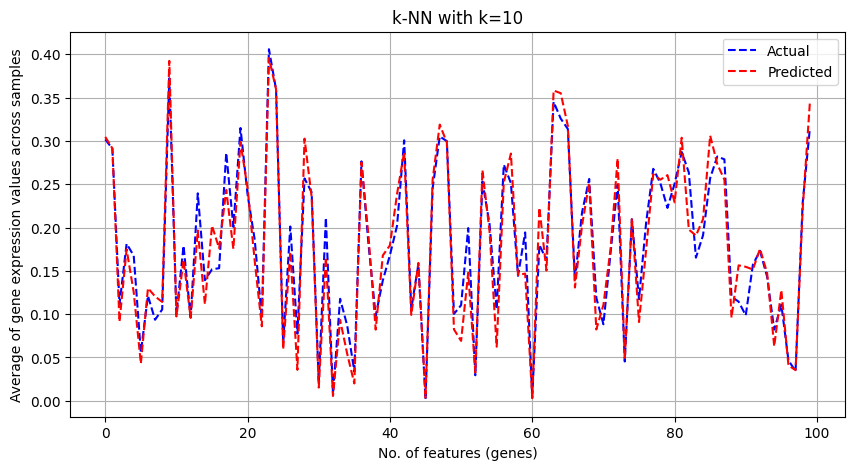

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('k-NN with k=10')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 6. PCA - Support Vector Regression (PCA-SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA

In [ ]:
n=200
pca = PCA(n_components=n)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

In [ ]:
with tf.device('/gpu:0'):
    y_mse=[]
    y_r2score = []
    for k in ['linear','poly','rbf','sigmoid']:
        print('kernel = ',k)
        mo_svr = MultiOutputRegressor(SVR(kernel=k,gamma='auto'))
        mo_svr.fit(x_train, y_train)
        y_pred = mo_svr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

kernel =  linear


KeyboardInterrupt: 

In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Plotting first 100 features

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('PCA-RF with 250 features and linear kernel')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# Comparison regression results from AE-MLP with PCA-MLP

Importing libraries

In [ ]:
from sklearn.decomposition import PCA

PCA-MLP

In [ ]:
n=100
with tf.device('/gpu:0'):
    #pca
    pca = PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    # MLP Multi-output Regression code goes here...
    num = n
    input_data = Input(shape=(num,))
    x = Dropout(0.2)(input_data)             # adding 20% dropout
    h = Dense(int(num * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)                        # adding 50% dropout
    h = Dense(int(num * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)                        # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=input_data, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'
    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)
    y_pred = mlpRegressor.predict(x_test)
    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))

Printing results

In [ ]:
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))